In [1]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import pertpy as pt
import mudata as mu
import yaml
import sys
import os

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
from sccoda.util import cell_composition_data as dat
from sccoda.util import comp_ana as mod
from sccoda.util import data_visualization as viz

Installed version 0.4.0 of pertpy is outdated. Newest version is 0.5.0!

2023-08-09 14:22:16.650026: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-09 14:22:19.602835: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Global seed set to 0
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/h/hollenberg/miniconda3/envs/scanpy/lib/python3.9/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightnin

In [2]:
with open("sccoda_analysis_input/config_galapagos_radiation.yml", 'r') as configfile:
        config = yaml.safe_load(configfile)

# path of partly preprocessed HLCA file used in this notebook:
adata_path = config['adata_path']
add_annotation = config.get('add_annotation', None)
cell_type_identifier=config['cell_type_identifier']
sample_identifier=config['sample_identifier']
covariate_obs=config['covariate_obs']
group1 = config['group1']
group2 = config['group2']
reference_cell_type=config['reference_cell_type']
fdr = 0.4
lfc_thresh = 0.5
dir_out = config['dir_out']

adata = sc.read(adata_path)

In [3]:

# load annotation if not in adata
if add_annotation is not None:
    adata.obs = pd.read_csv(add_annotation)

adata = adata[adata.obs[covariate_obs].isin([group1, group2]) ]

meta = adata.obs[[covariate_obs, sample_identifier]].drop_duplicates().set_index(sample_identifier)
scc_dat = dat.from_scanpy(
    adata,
    cell_type_identifier=cell_type_identifier,
    sample_identifier=sample_identifier,
    covariate_df=meta
)
scc_dat
sccoda_mod = mod.CompositionalAnalysis(
    scc_dat,
    formula=covariate_obs,
    reference_cell_type=reference_cell_type,
)
sccoda_res = sccoda_mod.sample_hmc()
#scc_dat.write(output_adata)


Automatic reference selection! Reference cell type set to NK cells
Zero counts encountered in data! Added a pseudocount of 0.5.


2023-08-09 14:25:55.731915: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-08-09 14:25:55.734301: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
  0%|                                                 | 0/20000 [00:00<?, ?it/s]2023-08-09 14:25:59.283704: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fc5f4167f50 initialized for platform Host (this does not guarantee that XLA will be used). De

MCMC sampling finished. (181.270 sec)
Acceptance rate: 75.8%


In [4]:
sc.settings.set_figure_params(
    dpi=100,
    color_map='plasma',
    dpi_save=200,
    vector_friendly=True,
    frameon=False,
    fontsize=10,
    figsize=(8,6),
    format='png',
)
# set thresholds
sccoda_res.set_fdr(est_fdr=fdr)

In [5]:
# build sccoda model
sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(adata, type="cell_level", generate_sample_level=True, 
                                cell_type_identifier=cell_type_identifier,
                                sample_identifier=sample_identifier, covariate_obs=[covariate_obs])

sccoda_model = pt.tl.Sccoda()
sccoda_data = sccoda_model.load(adata, type="cell_level", generate_sample_level=True, 
                                cell_type_identifier=cell_type_identifier,
                                sample_identifier=sample_identifier, covariate_obs=[covariate_obs])

sccoda_data

MuData object with n_obs × n_vars = 343142 × 23765
  2 modalities
    rna:	343071 x 23746
      obs:	'Unnamed: 0', 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ambient_RNA', 'percent_mito', 'percent_ribo', 'S.Score', 'G2M.Score', 'Phase', 'DF_doublet_score', 'DF_call_10pct', 'DF_call_1pct', 'DF_prediction', 'tube_ID', 'SAMP_ID', 'PROJ_bioinf_id', 'PROJ_glpg_id', 'PROJ_area', 'PROJ_species', 'PROJ_tissue', 'PROJ_tissue_detail', 'PROJ_biological_system', 'SAMP_subject_ID', 'SAMP_condition', 'SAMP_treatment', 'SAMP_stage', 'SAMP_exp_group', 'SAMP_sex', 'macrogen_sample_no', 'cell_conc_perml', 'cell_viability_pct', 'aggregates_pct', 'SC_prep', 'library_conc_ng_ul', 'library_size_bp', 'dataset', 'BW_sacrifice_g', 'perc_BW_change_rdm', 'col1_area_pct', 'MitochondrialRatio', 'RibosomalRatio', 'nCount_SCT', 'nFeature_SCT', 'clust_res0.6', 'clust_res0.9', 'clust_res1.2', 'clust_res1.5', 'ident', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden', 'annotation', 'scCODA_sample_id'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'DF_call_10pct_colors', 'Phase_colors', 'SAMP_ID_colors', 'SAMP_condition_colors', 'SAMP_exp_group_colors', 'SAMP_stage_colors', 'SC_prep_colors', 'ident_colors', 'neighbors', 'pca', 'tube_ID_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'log1p_norm', 'logcounts'
      obsp:	'connectivities', 'distances'
    coda:	71 x 19
      obs:	'SAMP_condition', 'SAMP_ID'
      var:	'n_cells'

In [6]:
group1_group2 = group1 + "_" + group2
sccoda_data.mod[group1_group2] = sccoda_data["coda"][sccoda_data["coda"].obs[covariate_obs].isin([group1, group2])].copy()
sccoda_data

MuData object with n_obs × n_vars = 343142 × 23765
  3 modalities
    rna:	343071 x 23746
      obs:	'Unnamed: 0', 'Row.names', 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'ambient_RNA', 'percent_mito', 'percent_ribo', 'S.Score', 'G2M.Score', 'Phase', 'DF_doublet_score', 'DF_call_10pct', 'DF_call_1pct', 'DF_prediction', 'tube_ID', 'SAMP_ID', 'PROJ_bioinf_id', 'PROJ_glpg_id', 'PROJ_area', 'PROJ_species', 'PROJ_tissue', 'PROJ_tissue_detail', 'PROJ_biological_system', 'SAMP_subject_ID', 'SAMP_condition', 'SAMP_treatment', 'SAMP_stage', 'SAMP_exp_group', 'SAMP_sex', 'macrogen_sample_no', 'cell_conc_perml', 'cell_viability_pct', 'aggregates_pct', 'SC_prep', 'library_conc_ng_ul', 'library_size_bp', 'dataset', 'BW_sacrifice_g', 'perc_BW_change_rdm', 'col1_area_pct', 'MitochondrialRatio', 'RibosomalRatio', 'nCount_SCT', 'nFeature_SCT', 'clust_res0.6', 'clust_res0.9', 'clust_res1.2', 'clust_res1.5', 'ident', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'outlier', 'mt_outlier', 'leiden', 'annotation', 'scCODA_sample_id'
      var:	'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
      uns:	'DF_call_10pct_colors', 'Phase_colors', 'SAMP_ID_colors', 'SAMP_condition_colors', 'SAMP_exp_group_colors', 'SAMP_stage_colors', 'SC_prep_colors', 'ident_colors', 'neighbors', 'pca', 'tube_ID_colors', 'umap'
      obsm:	'X_pca', 'X_umap'
      varm:	'PCs'
      layers:	'log1p_norm', 'logcounts'
      obsp:	'connectivities', 'distances'
    coda:	71 x 19
      obs:	'SAMP_condition', 'SAMP_ID'
      var:	'n_cells'
    RAD_SHAM:	71 x 19
      obs:	'SAMP_condition', 'SAMP_ID'
      var:	'n_cells'

<AxesSubplot: xlabel='Cell type', ylabel='Proportion'>

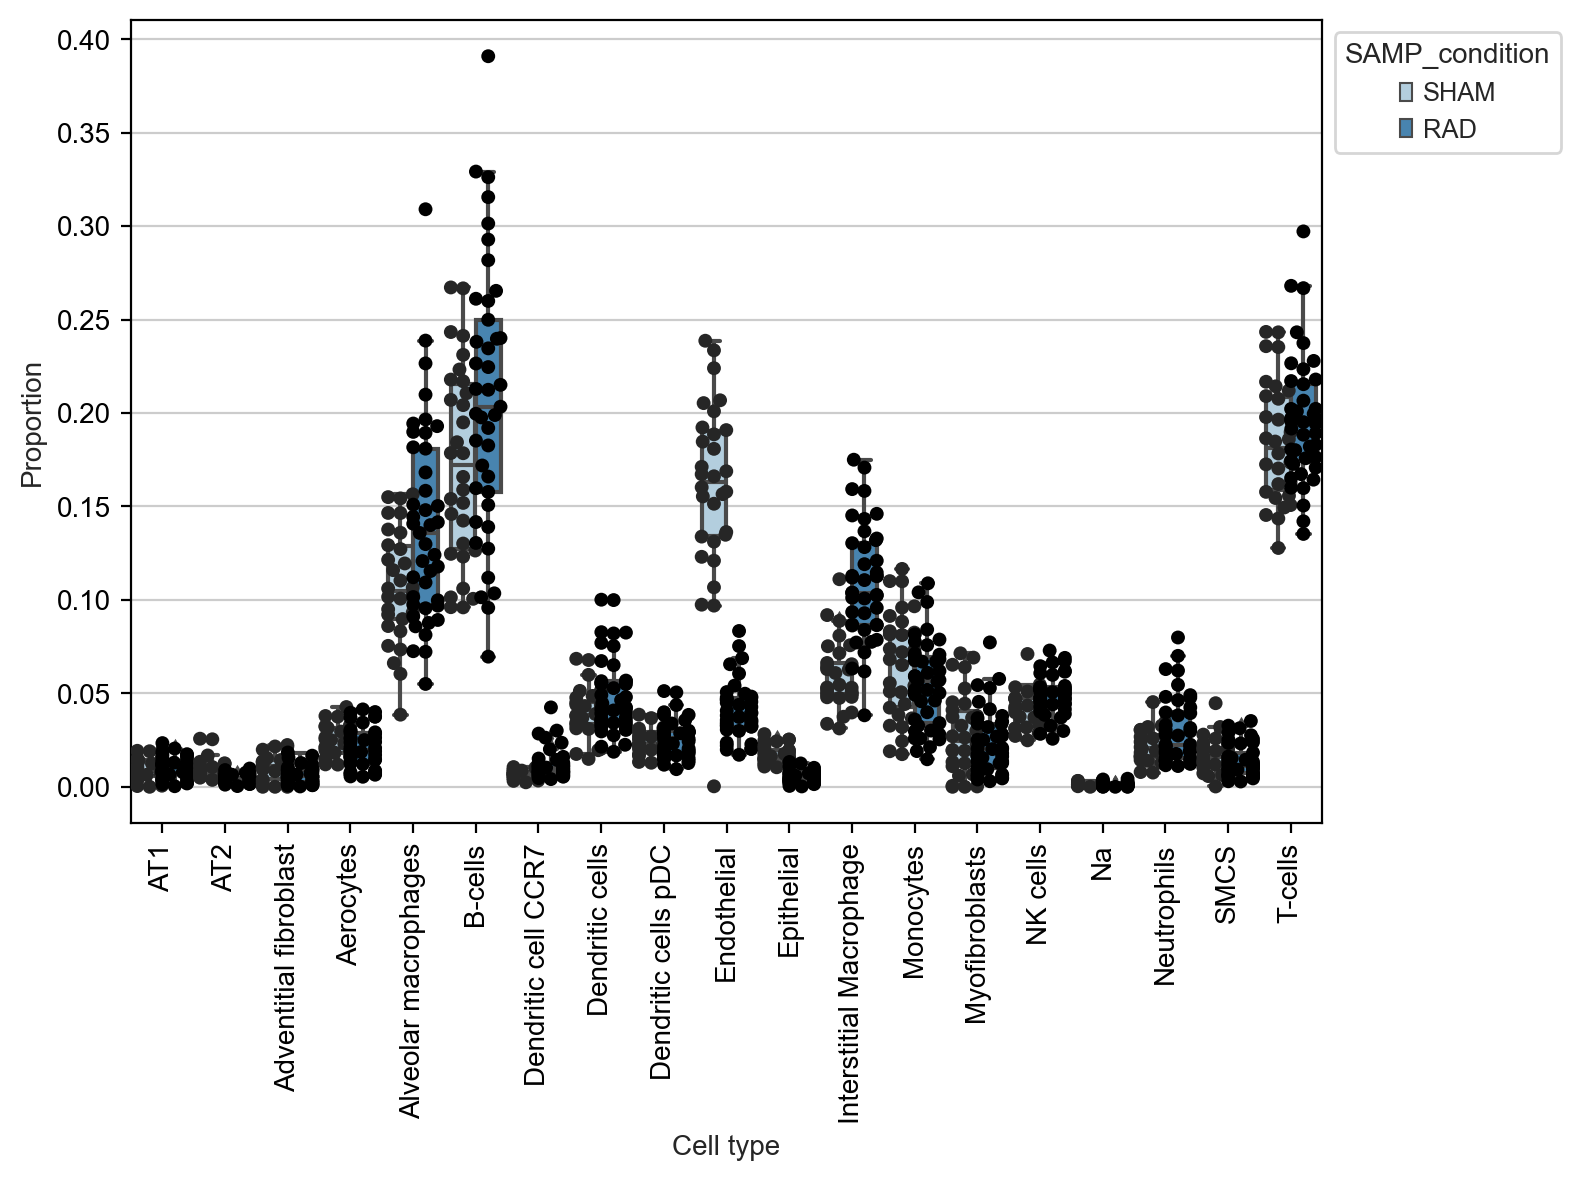

In [7]:
pt.pl.coda.boxplots(sccoda_data, modality_key=group1_group2, feature_name=covariate_obs, add_dots=True)

In [8]:
#run_analysis("sccoda_analysis_input/" + "config_galapagos_radiation.yml")